In [1]:
# Load packages
from datetime import datetime
import logging
import math
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import scipy
import sys

from scipy.stats import chisquare
from sklearn.model_selection import KFold, cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats.multicomp
from statsmodels.genmod.families import family, links

# Set up logging
from analytics.util.analytics_logger import GetAnalyticsLogger
import logging
logger = GetAnalyticsLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('analytics')
logger.setLevel(logging.INFO)

# Snapshots
from arivale_data_interface import *

# set Seed
np.random.seed(123)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-dnzzb4h3 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# declare universal variables
SUFFIX = ' (protein)'

In [3]:
def add_suffix_to_column_names(df, suffix):
    new_columns = {}
    for column in df.columns:
        if column != 'Patient-ID':
            new_column = column + suffix
        else:
            new_column = column
        new_columns[column] = new_column
    df.rename(columns=new_columns, inplace=True)
    return df


def calc_chi_square(dict_obs, dict_exp):
    list_obs, list_exp = [], []
    total_obs = sum(dict_obs.values())
    total_exp = sum(dict_exp.values())
    for key in dict_obs.keys():
        list_obs.append(dict_obs[key])
        list_exp.append(dict_exp[key])
    chi_test = chisquare(f_obs=list_obs, f_exp=list_exp)
    print(chi_test)
    
def create_binary_dict(df, col):
    d = {}
    d['No'] = len(df[df[col] == 0])
    d['Yes'] = len(df[df[col] == 1])
    return d

In [4]:
dfpb = pd.read_table('data/proteins-final.csv', sep=',', dtype={'Patient-ID':str})
dfpb = add_suffix_to_column_names(dfpb, SUFFIX)
dfmb = pd.read_table('data/metabolites-final.csv', sep=',', dtype={'Patient-ID':str})
dfmb.replace(0, np.nan, inplace=True)
dfmirna = pd.read_table('data/mirna-final.csv', sep=',', dtype={'Patient-ID':str})
dfmirna.replace(0, np.nan, inplace=True)
dftb = pd.read_table('data/transcripts-final.csv', sep=',', dtype={'Patient-ID':str})
dftb.replace(0, np.nan, inplace=True)

dfp_analyte = pd.read_table('data/protein-meta-final.csv', sep=',')
dfm_analyte = pd.read_table('data/metabolites-meta-final.csv', sep=',')
dfmirna_analyte = pd.read_table('data/mirna-meta-final.csv', sep=',')
dft_analyte = pd.read_table('data/transcripts-meta-final.csv', sep=',')

df_clinical = pd.read_table('data/metadata-final.csv', sep=',', dtype={'Patient-ID':str})
df_clinical = df_clinical[df_clinical['Condition']!='Control PTD']
df_clinical = df_clinical[df_clinical['InfSex']>=0]

In [5]:
dfmb.shape, dfmirna.shape, dfpb.shape, dftb.shape, df_clinical.shape

((341, 1033), (318, 2416), (343, 461), (318, 52084), (328, 24))

# Set up annotations

In [6]:
metam = get_snapshot('metabolomics_metadata')
metam['CHEMICAL_ID'] = metam['CHEMICAL_ID'].astype(str)
metap = get_snapshot('proteomics_metadata')

metabolites = {}
for index, row in dfm_analyte.iterrows():
    metabolites[row['CHEMICAL_NAME']] = {'name': row['CHEMICAL_NAME'], 'sub_group': row['SUB_PATHWAY'], 'super_group': row['SUPER_PATHWAY']}
proteins = {}
for index, row in dfp_analyte.iterrows():
    proteins[row['Assay'] + SUFFIX] = {'name': row['Assay'], 'sub_group': None, 'super_group': row['Panel']}
miRNAs = {}
for index, row in dfmirna_analyte.iterrows():
    miRNAs[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
transcripts = {}
for index, row in dft_analyte.iterrows():
    transcripts[row['Transcript']] = {'name': row['Transcript'], 'sub_group': None, 'super_group': None}
    
# print the number of included analytes
print('Metabolites:', str(len(metabolites)))
print('MiRNAs:', str(len(miRNAs)))
print('Proteins:', str(len(proteins)))
print('Transcripts:', str(len(transcripts)))
print('Total:', str(len(metabolites)+len(proteins)+len(transcripts)))

/shared-libs/arivale-data-interface/pylib/arivale_data_interface/snapshots_interface.py:122: FutureWarning: The default value of regex will change from True to False in a future version.
  t = pandas.to_datetime(x.str.replace("^arivale_snapshot.*(\\d{4}-\\d{2}-\\d{2}_\\d{4})$", "\\1"), format="%Y-%m-%d_%H%M")
/shared-libs/arivale-data-interface/pylib/arivale_data_interface/snapshots_interface.py:227: FutureWarning: The default value of regex will change from True to False in a future version.
  colnames = hdr.loc[~hdr.str.contains("^#")].head(1).str.replace("\n$","")
/shared-libs/arivale-data-interface/pylib/arivale_data_interface/snapshots_interface.py:232: FutureWarning: The default value of regex will change from True to False in a future version.
  hdr = hdr.loc[hdr.str.contains("^#")].str.replace("\n$","")
/shared-libs/arivale-data-interface/pylib/arivale_data_interface/snapshots_interface.py:174: FutureWarning: The default value of regex will change from True to False in a future

Metabolites: 1032
MiRNAs: 2414
Proteins: 452
Transcripts: 51174
Total: 52658


In [7]:
# Drop missingness and non-varying values
thresh_missingness = 0.8
thresh_unique = 0.5
thresh_mirna_read_counts = 10
thresh_rna_read_counts = 500

minNonNA = dfmb.shape[0] * thresh_missingness
dfmb.dropna(thresh=minNonNA, axis=1, inplace=True)
minUnique = dfmb.nunique()/len(dfmb)
col_drop = minUnique[minUnique < thresh_unique].index
dfmb.drop(columns=col_drop, inplace=True)

minNonNA = dfmirna.shape[0] * thresh_missingness
dfmirna.dropna(thresh=minNonNA, axis=1, inplace=True)
minUnique = dfmirna.nunique()/len(dfmirna)
col_drop = minUnique[minUnique < thresh_unique].index
dfmirna.drop(columns=col_drop, inplace=True)
col_sums = dfmirna.sum()
col_sums.drop(col_sums.index[1], inplace=True)
col_drop = col_sums[col_sums < thresh_mirna_read_counts].index
dfmirna.drop(columns=col_drop, inplace=True)

minNonNA = dfpb.shape[0] * thresh_missingness
dfpb.dropna(thresh=minNonNA, axis=1, inplace=True)
minUnique = dfpb.nunique()/len(dfpb)
col_drop = minUnique[minUnique < thresh_unique].index
dfpb.drop(columns=col_drop, inplace=True)

minNonNA = dftb.shape[0] * thresh_missingness
dftb.dropna(thresh=minNonNA, axis=1, inplace=True)
minUnique = dftb.nunique()/len(dftb)
col_drop = minUnique[minUnique < thresh_unique].index
dftb.drop(columns=col_drop, inplace=True)
col_sums = dftb.sum()
col_sums.drop(col_sums.index[1], inplace=True)
col_drop = col_sums[col_sums < thresh_rna_read_counts].index
dftb.drop(columns=col_drop, inplace=True)

dfm_analyte = list(set(metabolites.keys()).intersection(dfmb.columns))
dfmirna_analyte = list(set(miRNAs.keys()).intersection(dfmirna.columns))
dfp_analyte = list(set(proteins.keys()).intersection(dfpb.columns))
dft_analyte = list(set(transcripts.keys()).intersection(dftb.columns))

# Get all analytes together
analytes = dfm_analyte + dfmirna_analyte + dfp_analyte + dft_analyte

# print the number of included analytes that pass missingness threshold
print('# Metabolites:', str(len(dfm_analyte)))
print('# MiRNAs:', str(len(dfmirna_analyte)))
print('# Proteins:', str(len(dfp_analyte)))
print('# Transcripts:', str(len(dft_analyte)))
print('# Total:', str(len(analytes)))


# without 50% uniqueness threshold
# Metabolites: 865
# MiRNAs: 826
# Proteins: 343
# Transcripts: 23810
# Total: 25844

# with at least 25% uniqueness threshold
# Metabolites: 865
# MiRNAs: 619
# Proteins: 343
# Transcripts: 13424
# Total: 15251

# with at least 50% uniqueness threshold
# Metabolites: 865
# MiRNAs: 448
# Proteins: 343
# Transcripts: 9582
# Total: 11238

# Metabolites: 865
# MiRNAs: 448
# Proteins: 343
# Transcripts: 9582
# Total: 11238


In [8]:
df_clinical.head()

,Patient-ID,Condition,LaborInitiation,MaternalAge,isAsian,isBlack,isNativeAmerican,isPacificIslander,isWhite,RaceMissing,...,Para,LaborOnset,Smoker,IllicitDrugUser,DeliveryMethod,PregnancyRelatedHypertension,FetalGrowthRestriction,Preeclampsia,InfSex,Birthweight
0,KH-1100,PTD,1,42.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0,0,0,0.0,2250.0
1,KH-1103,PTD,1,32.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0,0,0,1.0,3060.0
2,KH-1132,Severe PE,0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,1,1.0,3490.0
3,KH-1149,Severe PE,0,29.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1,0,1,0.0,1545.0
4,MJ-0006,FGR,0,32.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0,1,0,1.0,2295.0


In [9]:
df_clinical['InfSex'] = np.random.permutation(df_clinical.InfSex)
df_clinical_female = df_clinical[df_clinical['InfSex']==0]
df_clinical_male = df_clinical[df_clinical['InfSex']==1]

df_female = df_clinical_female.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
df_female = df_female.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
df_female = df_female.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
df_female = df_female.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
df_female = df_female.fillna(-1)

df_male = df_clinical_male.merge(dfpb[['Patient-ID'] + list(dfp_analyte)], on=['Patient-ID'], how='inner')
df_male = df_male.merge(dfmb[['Patient-ID'] + list(dfm_analyte)], on=['Patient-ID'], how='left')
df_male = df_male.merge(dfmirna[['Patient-ID'] + list(dfmirna_analyte)], on=['Patient-ID'], how='left')
df_male = df_male.merge(dftb[['Patient-ID'] + list(dft_analyte)], on=['Patient-ID'], how='left')
df_male = df_male.fillna(-1)

In [10]:
df_female.shape, df_male.shape

((157, 11262), (164, 11262))

# Adjust values for ordinary least squares model

In [11]:
df_female['WksGestSquared'] = df_female['WksGest'] ** 2
df_female['MaternalAgeSquared'] = df_female['MaternalAge'] ** 2
df_female['PregravidBMISquared'] = df_female['PregravidBMI'] ** 2

df_male['WksGestSquared'] = df_male['WksGest'] ** 2
df_male['MaternalAgeSquared'] = df_male['MaternalAge'] ** 2
df_male['PregravidBMISquared'] = df_male['PregravidBMI'] ** 2

In [12]:
# Adjust values for ordinary least squares model

# Train Models

In [13]:
DROP_COLS = [
            'Patient-ID', 'Grav', 'DeliveryMethod', 
            'Para', 'Ethnicity', 'isAsian', 
            'isBlack', 'Condition', 'isWhite',
            'InfSex', 'Birthweight', 'LaborOnset',
            'WksGestSquared', 'MaternalAge',
            'MaternalAgeSquared', 'PregravidBMI'
             ]

In [14]:
def detect_outliers(data):
    
    # if no data is passed return False
    if len(data) == 0:
        False
        
    # Calculate z-scores
    z_scores = scipy.stats.zscore(data)
    
    # Define a z-score threshold for outliers (e.g., |z-score| > 3)
    threshold = 3
    
    # Identify extreme outliers
    extreme_outliers = data[abs(z_scores) > threshold]
    
    # if extreme outliers compose more than 2.5% of the data then mark it as extreme outliers present
    if len(extreme_outliers)/len(data) > 0.025:
        return True
    
    return False


def log_sig_analytes(df, feature):
    logger.info('Analytes that are significantly regulated by {}'.format(feature))
    for analyte in df['Analyte']:
        logger.info('{}'.format(analyte))
    logger.info('\n')


def run_glm(dat, analytes, sex, max_run=None):
    
    fhandler = logging.FileHandler(filename='output/glm.single.' + sex + '.all.miniDP3.log', mode='a')
    logger.addHandler(fhandler)
    f_failed = open('output/failed.glm.single.' + sex + '.all.miniDP3.txt', mode='w')
    f_output_model_eval = open('glm.single.' + sex + '.ols.model.evaluation.txt', mode='w')
    f_output = 'output/glm.single.' + sex + '.all.miniDP3.txt'
    f_output_sig = 'output/glm.single.' + sex + '.sig.miniDP3.txt'
         
    count = 0 
    done = 0
    skipped = 0
    completed = 0

    results = []
    results_sig = []
    columns = list(dat.columns)

    start_time = datetime.now()
    
    for analyte in analytes:
        
        # Default is gaussian- only switch to gamma if the analyte levels follow a non-normal distribution
        family_type = family.Gaussian()
        #family_type = family.Gaussian(link=sm.families.links.log())
        family_type.link = links.identity()
        family_name = 'Gaussian'
        #family_name = 'Log Normal Distribution'
        family_link = 'Identity'
        
        sub = dat[['Patient-ID', analyte, 'WksGest', 'PregravidBMISquared', 'LaborInitiation', 'Smoker', 'IllicitDrugUser']].copy()
        sub.rename(columns={analyte:'Analyte'}, inplace=True)
        sub['Analyte'] = sub['Analyte'].astype(np.float64)
        
        # log transfrom data
        # sub['Analyte'] = np.log(sub['Analyte'])
        
        # evaluate if there are extreme values
        extreme_outliers = detect_outliers(sub['Analyte'])
        
        # evaluate data normality using an anderson darling test
        ks_statistic, ks_p_value = scipy.stats.kstest(sub['Analyte'], 'norm')
        
        # if data is skewed or fails a normality test (with Bonferonni multiple hypothesis correction), then use the gamma family
        if abs(sub['Analyte'].skew()) > 1.5 or ks_p_value < 0.05:

            # Set any zero values to 1/2 the smallest value
            sub.loc[sub['Analyte']==0, analyte] = (sub.loc[sub['Analyte']>0, 'Analyte'].min() / 2.0)

            family_type = family.Gamma()
            family_type.link = links.log()
            family_name = 'Gamma'
            family_link = 'Log'

        try:
            ols_model = 'Analyte ~ WksGest + PregravidBMISquared + C(LaborInitiation) + C(Smoker) + C(IllicitDrugUser)'
            model = smf.glm(ols_model, data=sub, family=family_type, missing='drop')
            if extreme_outliers:
                # Fit the robust GLM model with robust Huber estimation
                fitted_model = model.fit(cov_type='hc0', maxiter=100)
            else:
                fitted_model = model.fit(maxiter=100)

            # Calculate the pseudo R-squared
            null_deviance = fitted_model.null_deviance
            residual_deviance = fitted_model.deviance
            pseudo_r_squared = 1 - (residual_deviance / null_deviance)
            
            # write to results
            results.append((analyte, len(fitted_model.fittedvalues), family_name, family_link, extreme_outliers, ks_statistic, ks_p_value, fitted_model.converged, *fitted_model.params, *fitted_model.pvalues, pseudo_r_squared))
            completed += 1

        except Exception as e:
            logger.info('Failed analytes {} with error {}'.format(analyte, str(e)))
            f_failed.write(analyte + '\n')
                  
        count += 1
        if (max_run is not None) and (count >= max_run):
            break

        if (count % 100) == 0:
            elapsed_time = datetime.now() - start_time    
            logger.info('Finished {} in {:.3f} seconds (skipped {})'.format(count, elapsed_time.total_seconds(), skipped))
    
    df = pd.DataFrame(results, columns=['Analyte', 'N', 'Model Family', 'Link Function', 'Extreme Outliers', 'K-S Statistic', 'K-S p-value', 'Converged', *fitted_model.params.index, *[str(x)+'_p' for x in fitted_model.pvalues.index], 'Pseudo_R_Squared'])
    df.sort_values(['WksGest_p'], ascending=True, inplace=True)
    f_failed.close()

    np.seterr(all='warn')
    logger.info('\nNumber of analytes analyzed: {}'.format(str(count)))
    logger.info('Number of analytes with converged formula: {}'.format(str(df.shape[0])))
    (adj_pval_index, adj_pval, _, _) = statsmodels.sandbox.stats.multicomp.multipletests(df.loc[~df['WksGest_p'].isnull(), 'WksGest_p'], alpha=0.05, method='fdr_bh')
    df.loc[~df['WksGest_p'].isnull(), 'pval_adj'] = adj_pval
    df.sort_values(['pval_adj'], ascending=True, inplace=True)
    df.to_csv(f_output, index=False, sep='\t')
    
    # filter for significance
    df = df[df['pval_adj']<0.05] #benjammini-hochman
    logger.info('Number of analytes whose levels are significantly regulated by gestational weeks as a function of pregravid bmi, labor initiation, smoking status, and illicit drug use status: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
    #bonferroni_correction = 0.05/count
    
    fhandler.close()
    f_failed.close()
    
    return df

In [15]:
'''
    # identify analytes significantly regulated by each feature and log info
    df_WksGest = df[df['WksGest_p'] < bonferroni_correction]
    logger.info('Number of analytes significantly regulated by gestational age: {}'.format(str(df_WksGest.shape[0])))
    log_sig_analytes(df_WksGest, 'Weeks of Gestation')

    df_PregravidBMI = df[df['PregravidBMISquared_p'] < bonferroni_correction]
    logger.info('Number of analytes significantly regulated by pregravid BMI: {}'.format(str(df_PregravidBMI.shape[0])))
    log_sig_analytes(df_PregravidBMI, 'Pregravid BMI')
    
    df_LaborInitiation = df[df['C(LaborInitiation)[T.1]_p'] < bonferroni_correction]
    logger.info('Number of analytes significantly regulated by labor onset: {}'.format(str(df_LaborInitiation.shape[0])))
    log_sig_analytes(df_LaborInitiation, 'Labor Initiation')
    
    df_Smoker = df[df['C(Smoker)[T.1.0]_p'] < bonferroni_correction]
    logger.info('Number of analytes significantly regulated by smoking status: {}'.format(str(df_Smoker.shape[0])))
    log_sig_analytes(df_Smoker, 'Smoker')
    
    # combine all significnatly regulated analytes into one dataframe
    df = pd.concat([df_WksGest, df_PregravidBMI, df_LaborInitiation, df_Smoker]).drop_duplicates() #bonferroni correction
    logger.info('\nBonferroni Correction: p<{}'.format(str(bonferroni_correction)))
    logger.info('Number of analytes whose levels are significantly regulated by Gestational Weeks, PregravidBMI, Labor Onset and/or Smoking Status: {}'.format(str(df.shape[0])))
    df.to_csv(f_output_sig, index=False, sep='\t')
 ''' 

"\n    # identify analytes significantly regulated by each feature and log info\n    df_WksGest = df[df['WksGest_p'] < bonferroni_correction]\n    logger.info('Number of analytes significantly regulated by gestational age: {}'.format(str(df_WksGest.shape[0])))\n    log_sig_analytes(df_WksGest, 'Weeks of Gestation')\n\n    df_PregravidBMI = df[df['PregravidBMISquared_p'] < bonferroni_correction]\n    logger.info('Number of analytes significantly regulated by pregravid BMI: {}'.format(str(df_PregravidBMI.shape[0])))\n    log_sig_analytes(df_PregravidBMI, 'Pregravid BMI')\n    \n    df_LaborInitiation = df[df['C(LaborInitiation)[T.1]_p'] < bonferroni_correction]\n    logger.info('Number of analytes significantly regulated by labor onset: {}'.format(str(df_LaborInitiation.shape[0])))\n    log_sig_analytes(df_LaborInitiation, 'Labor Initiation')\n    \n    df_Smoker = df[df['C(Smoker)[T.1.0]_p'] < bonferroni_correction]\n    logger.info('Number of analytes significantly regulated by smoking

In [16]:
os.remove('output/glm.single.randomGroup1.all.miniDP3.log')
os.remove('output/failed.glm.single.randomGroup1.all.miniDP3.txt')
os.remove('output/glm.single.randomGroup1.all.miniDP3.txt')
os.remove('output/glm.single.randomGroup1.sig.miniDP3.txt')
glm_female = run_glm(df_female, analytes, 'randomGroup1')

/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1132: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_params = np.zeros(self.exog.shape[1], np.float)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:697: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:698: Runtime

<AxesSubplot:>

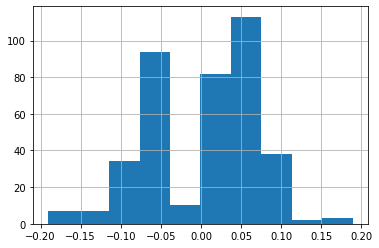

In [17]:
glm_female['WksGest'].hist()

<AxesSubplot:>

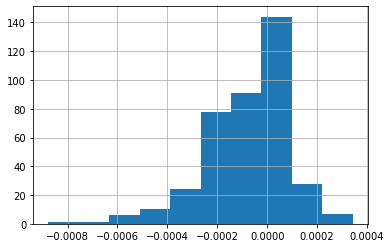

In [18]:
glm_female['PregravidBMISquared'].hist()

<AxesSubplot:>

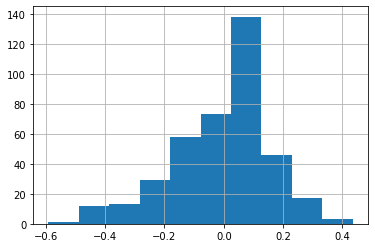

In [19]:
glm_female['C(LaborInitiation)[T.1]'].hist()

<AxesSubplot:>

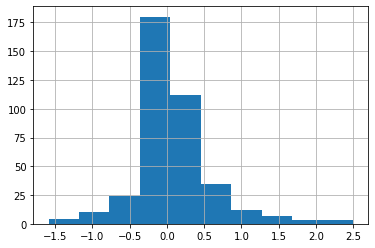

In [20]:
glm_female['C(Smoker)[T.1.0]'].hist()

<AxesSubplot:>

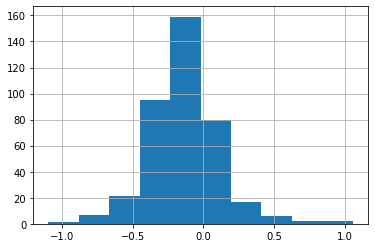

In [21]:
glm_female['C(IllicitDrugUser)[T.1.0]'].hist()

<AxesSubplot:>

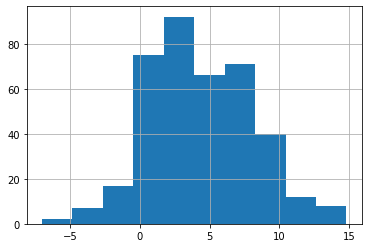

In [22]:
glm_female['Intercept'].hist()

In [23]:
os.remove('output/glm.single.randomGroup2.all.miniDP3.log')
os.remove('output/failed.glm.single.randomGroup2.all.miniDP3.txt')
os.remove('output/glm.single.randomGroup2.all.miniDP3.txt')
os.remove('output/glm.single.randomGroup2.sig.miniDP3.txt')
glm_male = run_glm(df_male, analytes, 'randomGroup2')

/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/generalized_linear_model.py:1132: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start_params = np.zeros(self.exog.shape[1], np.float)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/links.py:517: RuntimeWarning: underflow encountered in exp
  return np.exp(z)
/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/statsmodels/genmod/families/family.py:697: RuntimeWarning: divide by zero encounte

<AxesSubplot:>

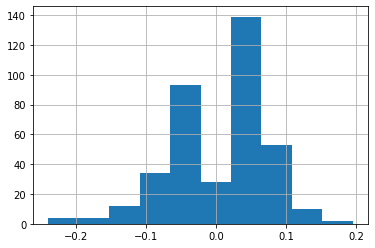

In [24]:
glm_male['WksGest'].hist()

<AxesSubplot:>

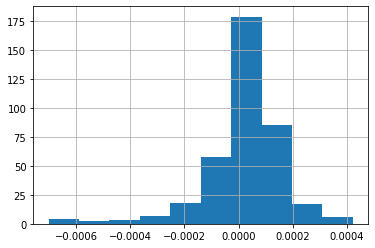

In [25]:
glm_male['PregravidBMISquared'].hist()

<AxesSubplot:>

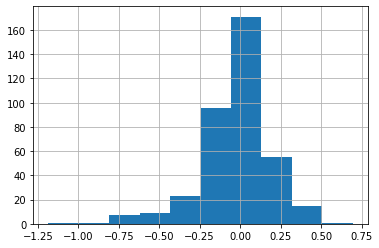

In [26]:
glm_male['C(LaborInitiation)[T.1]'].hist()

<AxesSubplot:>

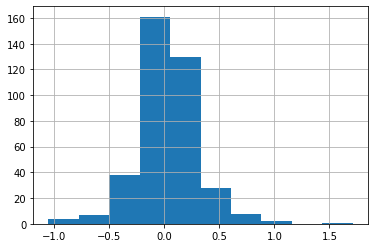

In [27]:
glm_male['C(Smoker)[T.1.0]'].hist()

<AxesSubplot:>

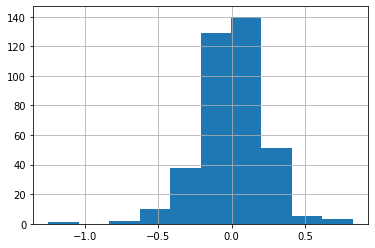

In [28]:
glm_male['C(IllicitDrugUser)[T.1.0]'].hist()

<AxesSubplot:>

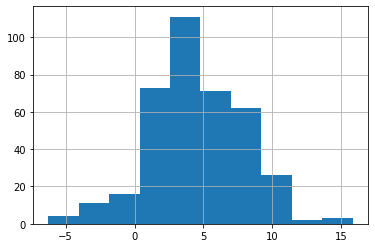

In [29]:
glm_male['Intercept'].hist()

In [30]:
def write_list_to_file(my_list, file_path):
    """
    Write a list to a text file with one item per line.

    Parameters:
    - my_list: List to be written to the file.
    - file_path: Path to the output text file.
    """
    # Open the file in write mode ('w')
    with open(file_path, 'w') as file:
        # Write each item in the list to a new line
        for item in my_list:
            file.write(str(item) + '\n')

In [31]:
# Number of analytes with significant regulation of gestational weeks in both groups: 157
# Number of analytes with significant regulation of gestational weeks in group 1 only: 233
# Number of analytes with significant regulation of gestational weeks in group 2 only: 222

list_sig_female_only = []
list_sig_male_only = []
list_sig_both = []

for item in glm_female['Analyte']:
    if item in list(glm_male['Analyte']):
        list_sig_both.append(item)
    else:
        list_sig_female_only.append(item)

for item in glm_male['Analyte']:
    if item not in list_sig_both:
        list_sig_male_only.append(item)
        
write_list_to_file(list_sig_both, 'output/sig_analytes_both_sexes.txt')
print('# Number of analytes with significant regulation of gestational weeks in both random groups: ' + str(len(list_sig_both)))
write_list_to_file(list_sig_female_only, 'output/sig_analytes_female_only.txt')
print('# Number of analytes with significant regulation of gestational weeks in group 1 only: ' + str(len(list_sig_female_only)))
write_list_to_file(list_sig_male_only, 'output/sig_analytes_male_only.txt')
print('# Number of analytes with significant regulation of gestational weeks in group 2 only: ' + str(len(list_sig_male_only)))

# Number of analytes with significant regulation of gestational weeks in males and females: 157
# Number of analytes with significant regulation of gestational weeks in females only: 233
# Number of analytes with significant regulation of gestational weeks in males only: 222


In [32]:
# save lists of analytes significantly regulated by gestational weeks to files
def write_list_to_file(l, f):
    w = open(f, mode='w')
    w.write(('\n').join(l))
    w.write('\n')
    w.close()

write_list_to_file(list(glm_female['Analyte']), 'analytes.glm.single.randomGroup1.sig.miniDP3.txt')
write_list_to_file(list(glm_male['Analyte']), 'analytes.glm.single.randomGroup2.sig.miniDP3.txt')
write_list_to_file(list_sig_both, 'analytes.glm.single.randomBothGroups.sig.miniDP3.txt')
write_list_to_file(list_sig_female_only, 'analytes.glm.single.randomGroup1Only.sig.miniDP3.txt')
write_list_to_file(list_sig_male_only, 'analytes.glm.single.randomGroup2Only.sig.miniDP3.txt')

/opt/conda/envs/arivale-py3/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


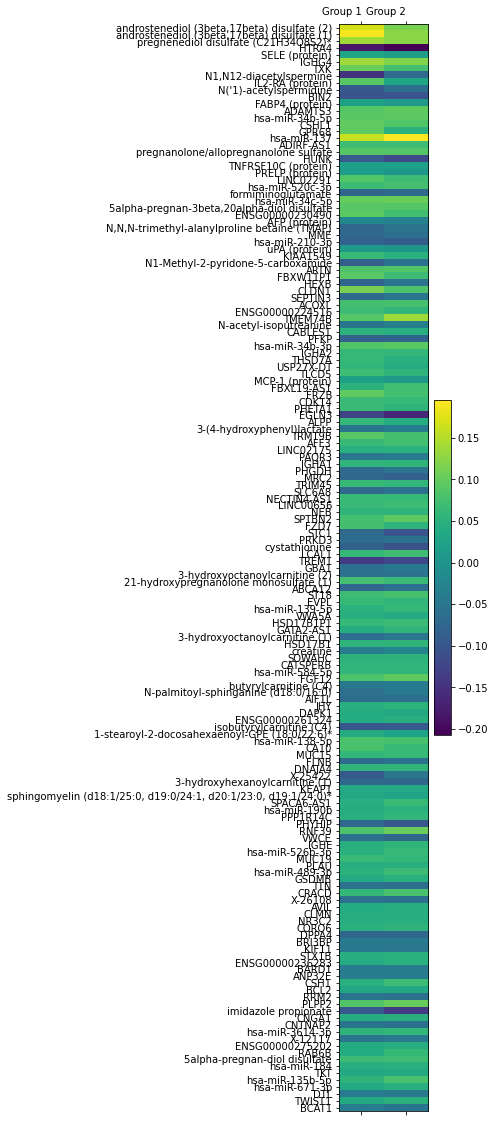

In [33]:
def make_list_of_slopes(df, analyte):
    l = []
    for item in analyte:
        row = df.loc[df['Analyte'] == item]
        slope = row['WksGest']
        l.append(slope)
    return l


def plot_heatmap(df_female, df_male, analytes):
    plt.rcParams['figure.figsize'] = [2, 20]
    gender = ['Group 1', 'Group 2']
    l_slopes_female = make_list_of_slopes(df_female, analytes)
    l_slopes_male = make_list_of_slopes(df_male, analytes)

    slopes = np.column_stack((l_slopes_female, l_slopes_male))


    fig, ax = plt.subplots()
    im = ax.imshow(slopes)
    
    # add colorbar
    cbm = ax.matshow(slopes, interpolation=None, aspect='auto');
    cb = plt.colorbar(cbm, ax=ax)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(gender)), labels=gender)
    ax.set_yticks(np.arange(len(analytes)), labels=analytes)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
             rotation_mode="anchor")

    fig.tight_layout()
    plt.show() 
    
plot_heatmap(glm_female, glm_male, list_sig_both)